# Task 3 – Exploratory Analysis (Python)

## 1. Data Understanding & Cleaning
- Load the datasets
- Handle missing values or outliers if necessary

In [2]:
#301360037
#maaz bobat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
# load the data into a pandas dataframe
df_events = pd.read_csv("../data/events.csv")
df_devices = pd.read_csv("../data/devices.csv")
df_users = pd.read_csv("../data/users.csv")

In [3]:
# ---- Explore Users -----
# number of rows and columns.
print(df_users.shape)
# Print first 5 rows to understand the data structure
print(df_users.head(), "\n")
# statistical summary of the dataset
print(df_users.describe(), "\n")
print("Missing values (Users):")
print(df_users.isnull().sum())
# Unique values for categorical columns
print("Unique Regions:  ", df_users["region"].unique())
print("Unique Platforms:", df_users["platform"].unique())


(121, 4)
    user_id signup_date         region  platform
0  739b720a  2023-04-21  United States       iOS
1  0aa3325c  2023-06-12             US       iOS
2  b5a2048e  2023-08-20             KR       Web
3  a4a70166  2023-05-26            can  3rdParty
4  2386e2a0  2023-01-18            USA   Android 

         user_id signup_date         region platform
count        121         121            121      121
unique       120         103              8        4
top     739b720a  2023-04-21  United States      iOS
freq           2           2             18       32 

Missing values (Users):
user_id        0
signup_date    0
region         0
platform       0
dtype: int64
Unique Regions:   ['United States' 'US' 'KR' 'can' 'USA' 'CA' 'JP' 'Canada']
Unique Platforms: ['iOS' 'Web' '3rdParty' 'Android']


In [4]:
# ----Explore Devices----
# number of rows and columns.
print("devices shape:", df_devices.shape)
# Print first 5 rows to understand the data structure
print(df_devices.head(), "\n")
# statistical summary of the dataset
print(df_devices.describe(), "\n")
print("Missing values (Devices):")
print(df_devices.isnull().sum())
# Unique values for categorical columns
print("Unique Networks:         ", df_devices["network"].unique())
print("Unique Device Types:     ", df_devices["device_type"].unique())
print("Unique Firmware Versions:", df_devices["firmware_version"].unique())
print("Unique Locations:        ", df_devices["location"].unique())
print(f"\nDuplicate device_ids: {df_devices.duplicated(subset='device_id').sum()}")

devices shape: (450, 6)
    device_id   user_id network device_type firmware_version location
0  d_f4abcb9e  89a25ef6    tuya         fan            1.0.3   Office
1  d_212b804b  2f555493    tuya  smart_plug            1.0.0      NaN
2  d_32b272b3  f41317b2    tuya      heater         3.5.beta      NaN
3  d_f6fe781d  ee413bc3    tuya         fan         3.5.beta      NaN
4  d_8555efd8  cd6e76a2    tuya  smart_bulb         3.5.beta     Home 

         device_id   user_id network device_type firmware_version location
count          450       425     450         450              450      342
unique         450       119       2           8                4        3
top     d_9f01e3d6  739b720a    tuya  thermostat            2.1.0     Home
freq             1        10     228          70              115      136 

Missing values (Devices):
device_id             0
user_id              25
network               0
device_type           0
firmware_version      0
location            108
dtype: 

In [5]:
# ----- Explore Events -----
print(df_events.shape)
print(df_events.head(), "\n")
print(df_events.describe(), "\n")
print(df_events.isnull().sum())

# Sample one payload per structure to understand what we're working with
print("Unique event_types:", df_events["event_type"].unique())
print("Unique event_values:", df_events["event_value"].unique())

# Inspect two raw payloads to identify the two structures
sample_metadata = df_events[df_events["payload"].str.contains('"metadata"')].iloc[0]
sample_status = df_events[df_events["payload"].str.contains('"status"')].iloc[0]

print("\n── Payload A ──")
print(json.dumps(json.loads(sample_metadata["payload"]), indent=2))
print("\n── Payload B ──")
print(json.dumps(json.loads(sample_status["payload"]), indent=2))

# Cross reference to confirm which structure belongs to which network
device_a = df_devices[df_devices["device_id"] == sample_metadata["device_id"]][
    ["device_id", "network"]
]
device_b = df_devices[df_devices["device_id"] == sample_status["device_id"]][
    ["device_id", "network"]
]
print("\nPayload A → network:", device_a["network"].values[0])
print("Payload B → network:", device_b["network"].values[0])

print(f"\nDuplicate event_ids:      {df_events.duplicated(subset='event_id').sum()}")
print(
    f"Duplicate timestamps:     {df_events.duplicated(subset='event_ts').sum()} — may indicate batch reporting or duplicate submissions"
)
print("\nNOTE: 'event_value' column contains only 'see_payload' for all rows.")
print("All meaningful values are embedded in the 'payload' JSON column.")
ayla_codes = {}
tuya_codes = {}
parse_errors = 0

for raw in df_events["payload"]:
    try:
        data = json.loads(raw)
    except (json.JSONDecodeError, TypeError):
        parse_errors += 1
        continue

    # Ayla structure — collect datapoint property names
    if "metadata" in data and "datapoint" in data:
        prop = data["datapoint"].get("property")
        if prop:
            ayla_codes[prop] = ayla_codes.get(prop, 0) + 1

    # Tuya structure — collect all status codes
    elif "status" in data and isinstance(data["status"], list):
        for item in data["status"]:
            code = item.get("code")
            if code:
                tuya_codes[code] = tuya_codes.get(code, 0) + 1

print(f"Parse errors: {parse_errors}")

print("\n── Ayla Payload Keys (datapoint.property) ──")
for k, v in sorted(ayla_codes.items(), key=lambda x: -x[1]):
    print(f"  {k:<30} {v} occurrences")

print("\n── Tuya Payload Keys (status[].code) ──")
for k, v in sorted(tuya_codes.items(), key=lambda x: -x[1]):
    print(f"  {k:<30} {v} occurrences")

(15000, 6)
  event_id   device_id event_type  event_value                  event_ts  \
0      e_0  d_87cfe321  telemetry  see_payload  2024-01-18T17:45:43.000Z   
1      e_1  d_fddd9d33  telemetry  see_payload  2024-02-04T16:18:19.000Z   
2      e_2  d_c5859fb6  telemetry  see_payload  2024-01-12T10:57:04.000Z   
3      e_3  d_de3f2763  telemetry  see_payload  2024-01-02T08:09:18.000Z   
4      e_4  d_8406c179  telemetry  see_payload  2024-01-23T01:15:16.000Z   

                                             payload  
0  {"metadata": {"oem_model": "door_sensor", "dsn...  
1  {"metadata": {"oem_model": "window_sensor", "d...  
2  {"status": [{"code": "generic_state", "value":...  
3  {"status": [{"code": "switch_led", "value": fa...  
4  {"status": [{"code": "generic_state", "value":...   

       event_id   device_id event_type  event_value                  event_ts  \
count     15000       15000      15000        15000                     15000   
unique    15000         450          1

In [6]:
# ---- Clean Users ----
# only US and Canada have the messy variants. Any region not in region_map will be set to Other
region_map = {
    "United States": "US",
    "USA": "US",
    "US": "US",
    "Canada": "CA",
    "can": "CA",
    "CA": "CA",
    "KR": "KR",
    "JP": "JP",
}
df_users["region"] = df_users["region"].map(region_map).fillna("Other")
# Parse signup_date to datetime
df_users["signup_date"] = pd.to_datetime(df_users["signup_date"])
#count duplicate
dupe_count = df_users.duplicated(subset="user_id", keep="first").sum()
# Drop duplicate user_id
df_users = df_users.drop_duplicates(subset="user_id", keep="first")
print(f"Duplicate user_ids dropped: {dupe_count}")
print(f"Shape: {df_users.shape}")
print(df_users["region"].value_counts().to_string())

Duplicate user_ids dropped: 1
Shape: (120, 4)
region
US    47
CA    45
KR    17
JP    11


In [7]:
# ---Clean Devices ---
df_devices["location"] = df_devices["location"].fillna("Unknown")
df_devices["user_id_missing"] = df_devices["user_id"].isnull()

orphan_events = df_events.merge(
    df_devices[["device_id", "user_id_missing"]], on="device_id", how="left"
)

print(f"Location nulls filled:       {(df_devices['location'] == 'Unknown').sum()}")
print(f"Orphan devices (no user_id): {df_devices['user_id_missing'].sum()}")
print(f"Events from orphan devices:  {orphan_events['user_id_missing'].sum()}")
print(
    f"Devices on beta firmware:    {(df_devices['firmware_version'] == '3.5.beta').sum()}"
)
beta_orphan_overlap = df_devices[
    (df_devices["firmware_version"] == "3.5.beta") & (df_devices["user_id_missing"])
].shape[0]
print(f"Beta firmware + no user_id:  {beta_orphan_overlap} — highest data quality risk devices")
print("Beta firmware (3.5.beta) may produce unreliable telemetry.")


Location nulls filled:       108
Orphan devices (no user_id): 25
Events from orphan devices:  749
Devices on beta firmware:    115
Beta firmware + no user_id:  4 — highest data quality risk devices
Beta firmware (3.5.beta) may produce unreliable telemetry.


In [8]:
# Clean Events (Handle Payload)
def parse_payload(raw):
    try:
        data = json.loads(raw)
    except (json.JSONDecodeError, TypeError):
        return pd.Series(
            {
                "source": "parse_error",
                "extracted_code": None,
                "extracted_value": None,
                "voltage": None,
                "current": None,
                "power": None,
                "temperature_c": None,
            }
        )

    # Ayla structure
    if "metadata" in data and "datapoint" in data:
        prop = data["datapoint"].get("property")
        value = data["datapoint"].get("value")
        return pd.Series(
            {
                "source": "ayla",
                "extracted_code": prop,
                "extracted_value": value,
                "voltage": None,
                "current": None,
                "power": None,
                "temperature_c": value if prop == "local_temperature" else None,
            }
        )

    # Tuya structure — loop all status items to capture multi-value events
    if "status" in data and isinstance(data["status"], list) and data["status"]:
        status_map = {
            item.get("code"): item.get("value")
            for item in data["status"]
            if item.get("code")
        }
        first = data["status"][0]
        return pd.Series(
            {
                "source": "tuya",
                "extracted_code": first.get("code"),
                "extracted_value": first.get("value"),
                "voltage": status_map.get("cur_voltage"),  # raw ÷ 10 = volts
                "current": status_map.get("cur_current"),  # raw ÷ 1000 = amps
                "power": status_map.get("cur_power"),  # raw ÷ 10 = watts
                "temperature_c": status_map.get("local_temperature"),
            }
        )

    return pd.Series(
        {
            "source": "unknown",
            "extracted_code": None,
            "extracted_value": None,
            "voltage": None,
            "current": None,
            "power": None,
            "temperature_c": None,
        }
    )


print("Parsing payload column (15,000 rows)...")
parsed = df_events["payload"].apply(parse_payload)
df_events = pd.concat([df_events, parsed], axis=1)

# Parse timestamp and extract date for daily aggregations
df_events["event_ts"] = pd.to_datetime(df_events["event_ts"], utc=True)
df_events["date"] = df_events["event_ts"].dt.date

# Convert extracted_value to numeric — booleans (True/False) become 1/0
df_events["extracted_value_numeric"] = pd.to_numeric(
    df_events["extracted_value"].apply(lambda x: int(x) if isinstance(x, bool) else x),
    errors="coerce",
)

# Scale raw Tuya electrical values to proper units
df_events["voltage_v"] = df_events["voltage"] / 10
df_events["current_a"] = df_events["current"] / 1000
df_events["power_w"] = df_events["power"] / 10

print("── Events Cleaned ──")
print(f"Shape: {df_events.shape}")
print(f"\nPayload source breakdown:")
print(df_events["source"].value_counts().to_string())
print(f"\nAll unique extracted codes:")
print(df_events["extracted_code"].value_counts().to_string())
print(f"\nDedicated measurement columns:")
print(f"  temperature_c: {df_events['temperature_c'].notna().sum()} readings")
print(f"  voltage_v:     {df_events['voltage_v'].notna().sum()} readings")
print(f"  current_a:     {df_events['current_a'].notna().sum()} readings")
print(f"  power_w:       {df_events['power_w'].notna().sum()} readings")

print(f"\nextracted_value_numeric non-null: {df_events['extracted_value_numeric'].notna().sum()} / {len(df_events)}")
print("Note: String values like 'online', 'open', 'closed' are intentionally NaN — use extracted_value for categorical analysis.")

dup_ts = df_events.duplicated(subset="event_ts").sum()
print(f"Duplicate timestamps in events: {dup_ts} — kept all rows, could be batch reporting from same device tick")

Parsing payload column (15,000 rows)...
── Events Cleaned ──
Shape: (15000, 18)

Payload source breakdown:
source
tuya    8319
ayla    6681

All unique extracted codes:
extracted_code
generic_state        4999
contact_state        3228
local_temperature    2092
switch_led           1890
switch_1             1430
connectivity         1361

Dedicated measurement columns:
  temperature_c: 2092 readings
  voltage_v:     1430 readings
  current_a:     1430 readings
  power_w:       1430 readings

extracted_value_numeric non-null: 8640 / 15000
Note: String values like 'online', 'open', 'closed' are intentionally NaN — use extracted_value for categorical analysis.
Duplicate timestamps in events: 24 — kept all rows, could be batch reporting from same device tick


In [9]:
# ---Verify + Final Summary--
df_check = df_events.merge(
    df_devices[["device_id", "network"]], on="device_id", how="left"
)
print(df_check.groupby(["network", "source"]).size())
print(f"Events with unknown device_id: {df_check['network'].isna().sum()}")

print("\n---- Final Dataset Summary ----")
print(f"Users:   {df_users.shape[0]} rows | Regions: {sorted(df_users['region'].unique())}")
print(f"Devices: {df_devices.shape[0]} rows | Networks: {df_devices['network'].unique().tolist()}")
print(f"Events:  {df_events.shape[0]} rows | Date range: {df_events['date'].min()} → {df_events['date'].max()}")
print("\n---- Data Quality Summary ----")
print(f"  Duplicate user_ids dropped:          1")
print(f"  Region variants normalized:          United States/USA → US, Canada/can → CA")
print(f"  Orphan devices (no user_id):         {df_devices['user_id_missing'].sum()}")
print(f"  Events from orphan devices:          {orphan_events['user_id_missing'].sum()}")
print(f"  Devices on beta firmware (3.5.beta): {(df_devices['firmware_version'] == '3.5.beta').sum()} — telemetry reliability risk")
print(f"  Beta firmware + no user_id:          {beta_orphan_overlap} — highest risk")
print(f"  Location nulls filled as 'Unknown':  {(df_devices['location'] == 'Unknown').sum()}")
print(f"  Duplicate event timestamps:          {df_events.duplicated(subset='event_ts').sum()} — kept, likely batch reporting")
print(f"  event_value column:                  placeholder only ('see_payload') — real values in parsed payload columns")
print(f"  extracted_value_numeric non-null:    {df_events['extracted_value_numeric'].notna().sum()} / {len(df_events)} rows")

network  source
ayla     ayla      6681
tuya     tuya      8319
dtype: int64
Events with unknown device_id: 0

---- Final Dataset Summary ----
Users:   120 rows | Regions: ['CA', 'JP', 'KR', 'US']
Devices: 450 rows | Networks: ['tuya', 'ayla']
Events:  15000 rows | Date range: 2024-01-01 → 2024-02-07

---- Data Quality Summary ----
  Duplicate user_ids dropped:          1
  Region variants normalized:          United States/USA → US, Canada/can → CA
  Orphan devices (no user_id):         25
  Events from orphan devices:          749
  Devices on beta firmware (3.5.beta): 115 — telemetry reliability risk
  Beta firmware + no user_id:          4 — highest risk
  Location nulls filled as 'Unknown':  108
  Duplicate event timestamps:          24 — kept, likely batch reporting
  event_value column:                  placeholder only ('see_payload') — real values in parsed payload columns
  extracted_value_numeric non-null:    8640 / 15000 rows


## 2. Visualizations
Produce at least 3 meaningful charts, such as:
- Event volume over time
- Events per device or per user
- Comparison between Ayla vs Tuya devices
- Highlight any anomalies or interesting patterns

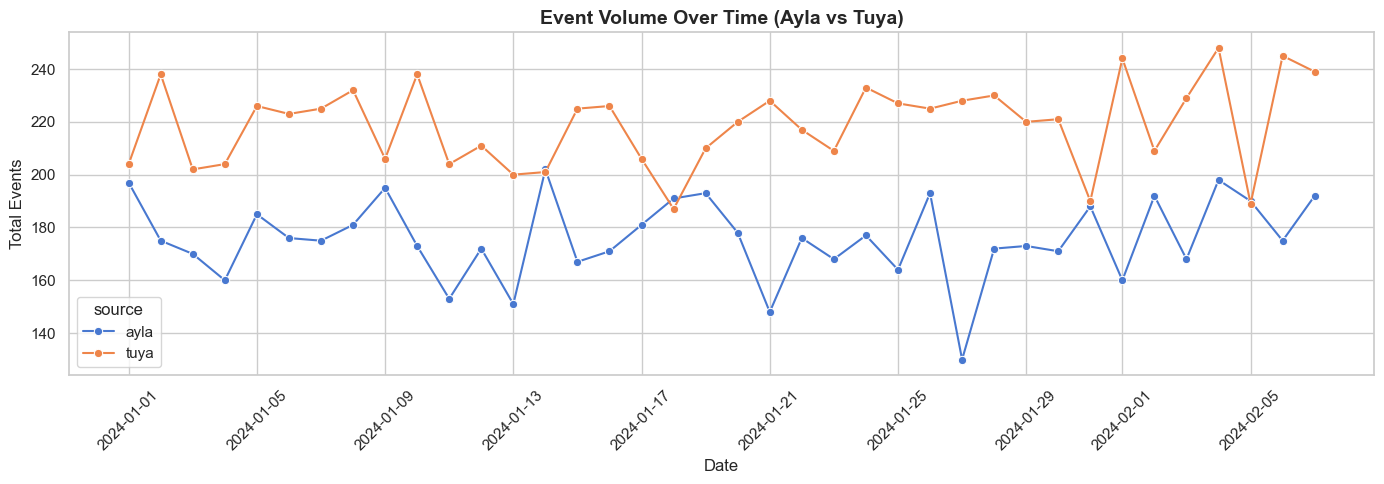

Saved: chart1_event_volume_over_time.png


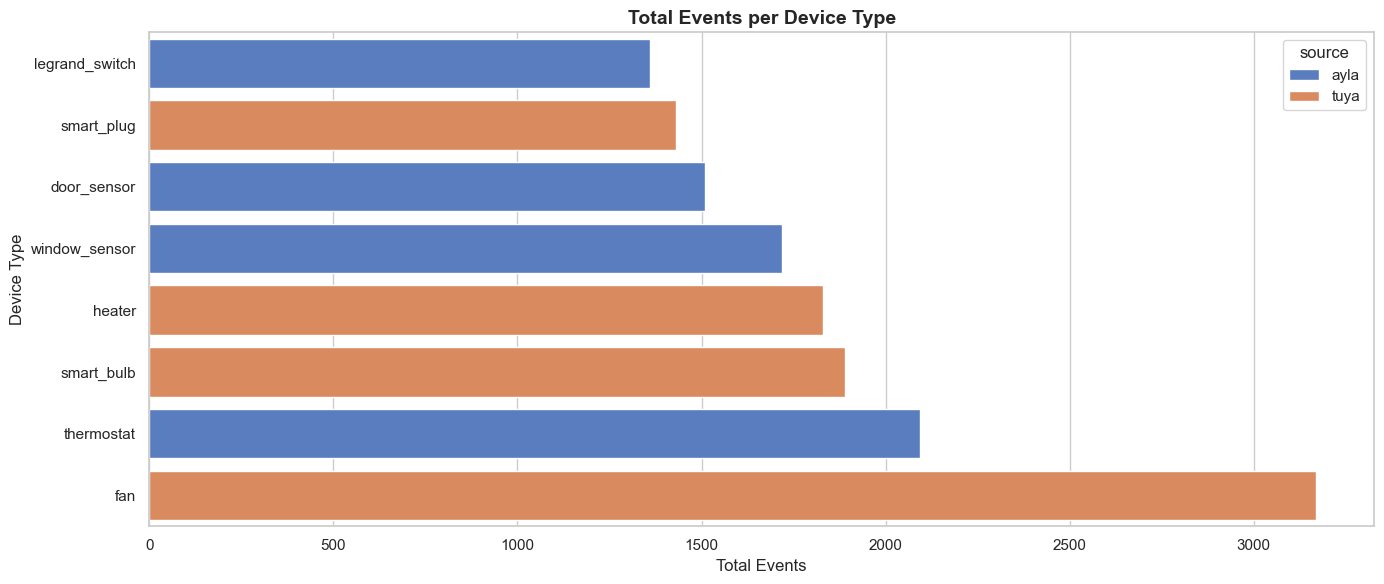

Saved: chart2_events_per_device_type.png


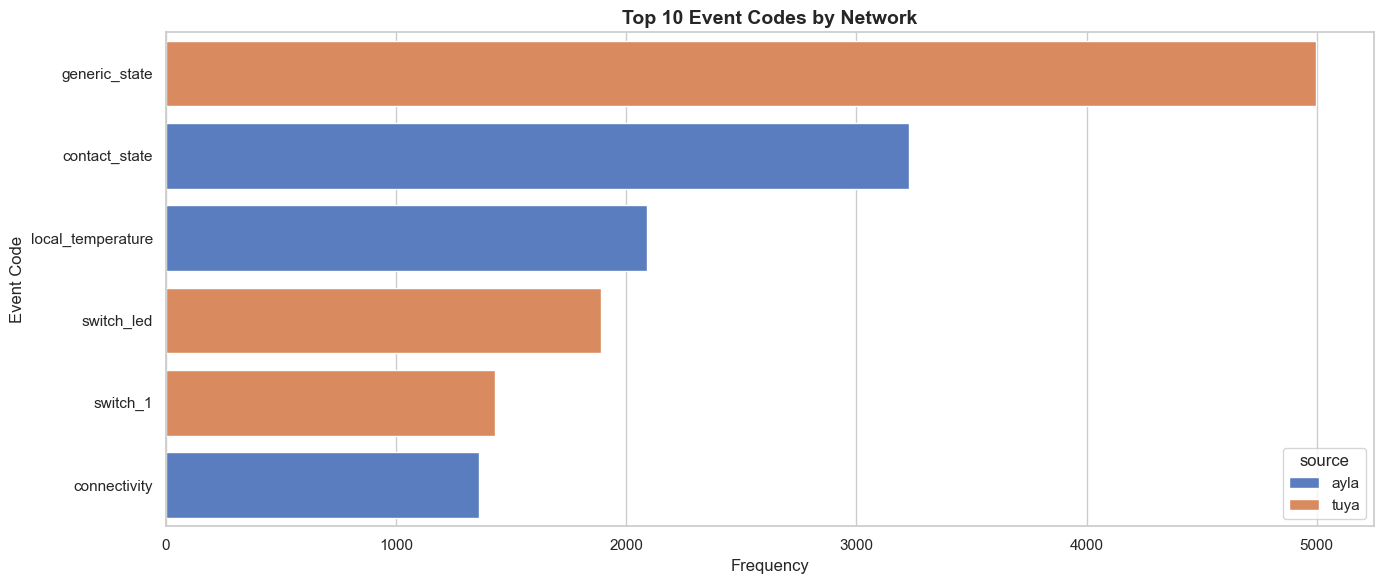

Saved: chart3_event_codes_ayla_vs_tuya.png


In [ ]:
import os

os.makedirs("../charts", exist_ok=True)

# Set visual theme
sns.set_theme(style="whitegrid", palette="muted")



# Chart 1: Event Volume Over Time (Line Chart)
fig, ax = plt.subplots(figsize=(14, 5))

daily_vol = df_events.groupby(["date", "source"]).size().reset_index(name="count")
sns.lineplot(data=daily_vol, x="date", y="count", hue="source", marker="o", ax=ax)

ax.set_title("Event Volume Over Time (Ayla vs Tuya)", fontsize=14, fontweight="bold")
ax.set_ylabel("Total Events")
ax.set_xlabel("Date")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("../charts/chart1_event_volume_over_time.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart1_event_volume_over_time.png")


# Chart 2: Events per Device Type (Horizontal Bar)
fig, ax = plt.subplots(figsize=(14, 6))

device_vol = df_events.merge(
    df_devices[["device_id", "device_type"]], on="device_id", how="left"
)
dev_type_counts = (
    device_vol.groupby(["device_type", "source"]).size().reset_index(name="count")
)

# Sort by total events per device type
order = (
    dev_type_counts.groupby("device_type")["count"]
    .sum()
    .sort_values(ascending=True)
    .index
)

sns.barplot(
    data=dev_type_counts, y="device_type", x="count", hue="source", ax=ax, order=order
)

ax.set_title("Total Events per Device Type", fontsize=14, fontweight="bold")
ax.set_xlabel("Total Events")
ax.set_ylabel("Device Type")

plt.tight_layout()
plt.savefig("../charts/chart2_events_per_device_type.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart2_events_per_device_type.png")



# Chart 3: Ayla vs Tuya Event Code Comparison (Horizontal Grouped Bar)
fig, ax = plt.subplots(figsize=(14, 6))

top_codes = df_events["extracted_code"].value_counts().nlargest(10).index
filtered_codes = df_events[df_events["extracted_code"].isin(top_codes)]

sns.countplot(
    data=filtered_codes, y="extracted_code", hue="source", order=top_codes, ax=ax
)

ax.set_title("Top 10 Event Codes by Network", fontsize=14, fontweight="bold")
ax.set_xlabel("Frequency")
ax.set_ylabel("Event Code")

plt.tight_layout()
plt.savefig(
    "../charts/chart3_event_codes_ayla_vs_tuya.png", dpi=150, bbox_inches="tight"
)
plt.show()
print("Saved: chart3_event_codes_ayla_vs_tuya.png")


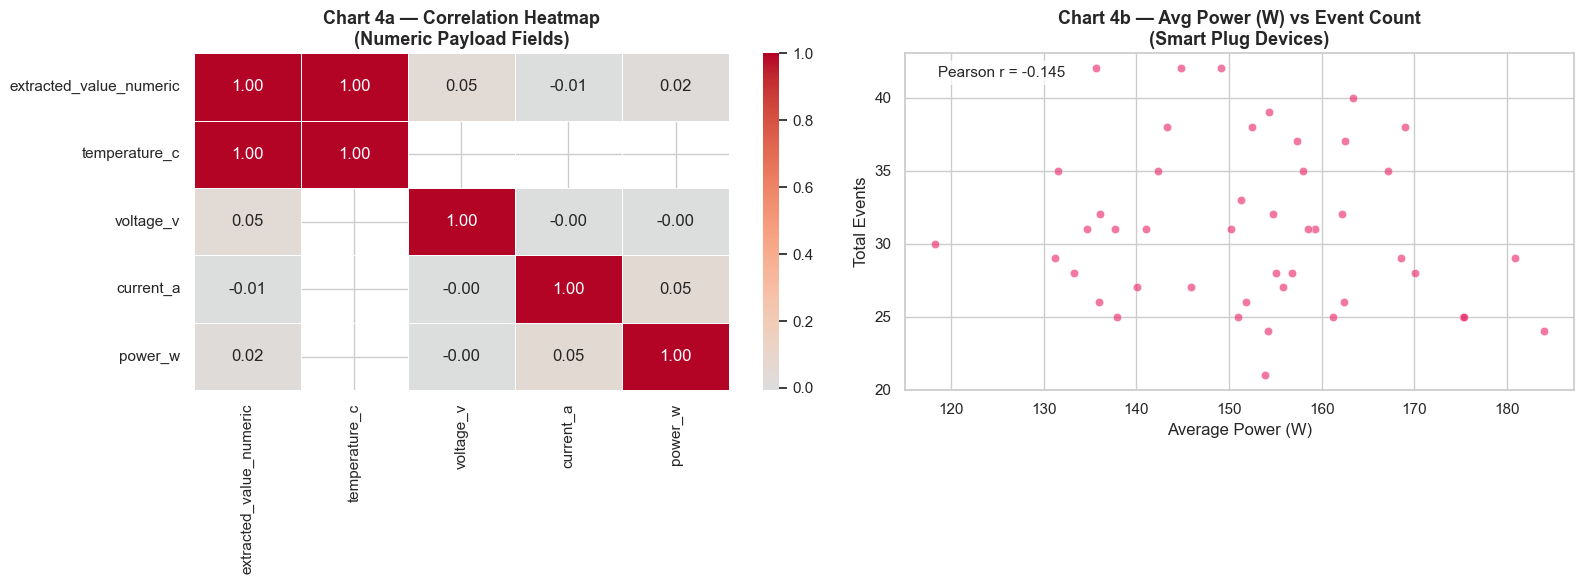

Saved: chart4_correlation.png


In [ ]:

# Chart 4: Correlation Heatmap + Scatter
# ---- Build merged DataFrame ----
df_merged = df_events.merge(
    df_devices[["device_id", "device_type", "network", "user_id", "firmware_version"]],
    on="device_id",
    how="left",
)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Chart 5a: Correlation Heatmap ----
numeric_cols = [
    "extracted_value_numeric",
    "temperature_c",
    "voltage_v",
    "current_a",
    "power_w",
]
corr_matrix = df_merged[numeric_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    ax=axes[0],
    center=0,
    linewidths=0.5,
)
axes[0].set_title(
    "Chart 4a — Correlation Heatmap\n(Numeric Payload Fields)",
    fontsize=13,
    fontweight="bold",
)

# ---- Chart 5b: Avg Power vs Avg Daily Events per Device ----
device_corr = (
    df_merged[df_merged["power_w"].notna()]
    .groupby("device_id")
    .agg(avg_daily_events=("event_id", "count"), avg_power=("power_w", "mean"))
    .reset_index()
)
r = device_corr["avg_power"].corr(device_corr["avg_daily_events"])

axes[1].scatter(
    device_corr["avg_power"],
    device_corr["avg_daily_events"],
    alpha=0.6,
    color="#E91E63",
    edgecolors="white",
    linewidth=0.5,
)
axes[1].annotate(
    f"Pearson r = {r:.3f}",
    xy=(0.05, 0.93),
    xycoords="axes fraction",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
)
axes[1].set_title(
    "Chart 4b — Avg Power (W) vs Event Count\n(Smart Plug Devices)",
    fontsize=13,
    fontweight="bold",
)
axes[1].set_xlabel("Average Power (W)")
axes[1].set_ylabel("Total Events")

plt.tight_layout()
plt.savefig("../charts/chart4_correlation.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart4_correlation.png")

# Task 4 – Hypotheses & Questions

1. Propose 2–3 hypotheses about user or device behavior.
2. Show how you would test each hypothesis with the available data.
3. Clearly state whether the data supports, partially supports, or does not support the hypothesis.

In [11]:
# Your code for hypothesis testing here

# Task 5 – Reflection

- What additional data would improve this analysis?
- What limitations prevent deeper insights?
- What would you explore next if this were Phase 0 of a larger project?

*Write your reflection here...*